In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import re
#from scipy.optimize import curve_fit
#import mdtraj as md
import os

In [40]:
def dir_to_trajs(directory):
    """
    loads atom positions from all LAMMPS files in given directory
    
    input directory: path of directory e.g. run3-100_dumplin (string)
    output: positions of all atoms at different times (numpy array) 
    """
    a = []
    #d = {}
    # iterate over files in
    # that directory
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file: 
        if os.path.isfile(f):
            #d['traj{0}'.format(re.findall(r'hello.([^]]*).lammpstrj', f)[0])] = np.loadtxt(f, skiprows=9, usecols=(1,2,3))
            a.append(np.loadtxt(f, skiprows=9, usecols=(1,2,3)))
    return np.asarray(a) #[-10:] #d

def trajs_to_SDs(a,atom1,atom2):
    """
    computes SD of two atoms for all times in given dictionary
    
    input a: atom positions at different times (dictionary)
    input atom1/atom2: two atoms of interest (integer)
    output: SDs of two atoms of interest for all times (1d array of length=#timestamps)
    """
    #SD = []
    #for key in a:
        #r1 = a[key][atom1-1]
        #r2 = a[key][atom2-1]
        #dist = np.linalg.norm(r1-r2)**2
        #SD.append(dist)
    #return np.asarray(SD)
    temp = a[:,atom1-1]-a[:,atom2-1]
    #SD = np.einsum("ij,ij->i", temp, temp) # did return wrong results (faster acc. to guy online)
    SD = np.linalg.norm(temp, axis=1)**2
    return SD

def dir_to_allSDs(directory,gendist):
    """
    computes SDs of every pair of atoms separated by a given genomic distance 
    for all LAMMPS files in directory
    
    input gendist: genomic distance of interest (integer)
    output: SDs for every two atoms separated by given genomic distance for all times 
            (array of shape [#atoms-gendist] x #timestamps)
    """
    trajs = dir_to_trajs(directory)
    a = []
    atom1 = 1
    while True:
        try: 
            a.append(trajs_to_SDs(trajs,atom1,atom1+gendist))
            atom1 += 1
        except: 
            break
    return np.asarray(a)

In [41]:
def allSDs_to_MSD(directory,gendist):
    allSDs = dir_to_allSDs(directory,gendist)
    nostart = np.delete(allSDs, obj=0, axis=1) # delete starting pos after SAW (ie first column)
    return np.mean(nostart), np.std(nostart, ddof=1) / np.sqrt(np.size(nostart))

In [4]:
def allMSDs(directory):
    gendist = 1
    MSDs = []
    errs = []
    while True:
        try:
            MSD, err = allSDs_to_MSD(directory,gendist)
            MSDs.append(MSD)
            errs.append(err)
            gendist += 1
        except:
            break
    return np.asarray(MSDs), np.asarray(errs)

In [30]:
# runtime when using all timestamps
%%time
directory = 'run3-100_dumplin'
MSDs, errs = allMSDs(directory)

Wall time: 2min 44s


In [33]:
# runtime only using the last 10 timestamps
%%time
directory = 'run3-100_dumplin'
MSDs, errs = allMSDs(directory)

Wall time: 2min 49s


In [44]:
# runtime not using dir_to_SDs (ie not loading the trajectories for every pair of atoms)
%%time
directory = 'run3-100_dumplin'
MSDs, errs = allMSDs(directory)

Wall time: 3.22 s


In [45]:
%%time
directory = 'run2-1000_dumplin'
MSDs, errs = allMSDs(directory)

Wall time: 3min 59s


<ErrorbarContainer object of 3 artists>

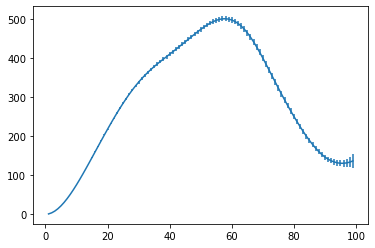

In [41]:
#print(MSDs)
#print(errs)
gendists = np.arange(1, len(MSDs)+1)
plt.errorbar(gendists, MSDs, yerr=errs)

<ErrorbarContainer object of 3 artists>

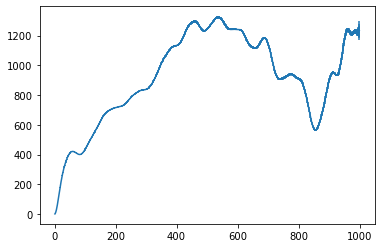

In [46]:
gendists = np.arange(1, len(MSDs)+1)
plt.errorbar(gendists, MSDs, yerr=errs)